# Population downscaling: Machine learning approach
* End-to-end framework for computing disaggregated population mapping using convolutional neural networks (CNNs).
* Using urban data extracted from the OpenStreetMap database, a set of urban features are generated which are used to perform population density estimates at a higher resolution.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from src.population.urban_features import get_Y_X_features_population_data

from keras import backend as K
from keras import optimizers
from keras.models import Sequential
from keras.layers import Activation, Flatten, Conv1D

import tensorflow
tensorflow.__version__

/home/steep/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'1.5.0'

## Urban features
* Load stored urban features and gridded population data (see "population_osm_cities.ipynb")

In [2]:
city_sel = "Lyon"

# Validation data
Y_test, X_test, X_columns = get_Y_X_features_population_data(cities_selection=[city_sel])
# Shape
print( "Validation data shape:", Y_test.shape, X_test.shape )

# Training data
Y_train, X_train, X_columns = get_Y_X_features_population_data(cities_skip=[city_sel])
# Shape
print( "Training data shape:", Y_train.shape, X_train.shape )

Validation data shape: (10068, 25) (10068, 25, 20)
Training data shape: (86904, 25) (86904, 25, 20)


## Population mapping

* Context: Available data
    * GPW data: resolution of 1km by 1km; world-wide coverage
    * INSEE data: (higher) resolution of 200m by 200m; limited coverage (France)
    * One square-grid of GPW's resolution is equivalent to 25 squares of INSEE's resolution

* Goal: Perform population density estimates at a higher resolution than available population-count data
    * Distribute population densities from an input square-resolution (GPW resolution) into 25-finer squares (INSEE resolution)
    * Model: $f(X_{1}, X_{2}, ... , X_{N})$ $=$ $< Y_{1}, Y_{2}, ... , Y_{N} >$
        * $X_{i}$ : Set of urban features associated to square $i$
        * $Y_{i}$ : Estimated population density associated to square $i$
        * $\sum_{i=1}^{N} Y_{i} = 1$
        
    * Actual estimated population: $Y_{i}$ * P
        * $Y_{i}$ : Estimated population density
        * P : Population count available in coarse-grained resolution
    * The actual population count can be retrieved by multiplying the estimated population-density at the fine-grid square by the total population count available in the coarse-grained square

* Training and validation:
    * Usage of INSEE's data as ground-truth, where 25-aggregated squares are equivalent to one GPW's square resolution


## Urban features

* Available urban features for each input square using INSEE resolution (population count data exist):
    * M² total residential usage
    * M² total activity usage
    * M² footprint residential usage
    * M² footprint activity usage
    * M² footprint mixed usage
    * Number of residential buildings
    * Number of activity buildings
    * Number of mixed buildings
    * Number of actvity POIs
    * Total number of building levels
    * Total number of buildings
    * Buildings built-up footprint relation [0%; 100%]
    * Sprawling indices: Dispersion
    * Sprawling indices: Land use mix
    * Densities estimation: Residential use
    * Densities estimation: Activity use
    * Densities estimation: Land use intensity (Residential + Activity)
    * Densities estimation: Commercial/industrial activity type use
    * Densities estimation: Shop activity type use
    * Densities estimation: Leisure/amenity activity type use

## Fully convolutional neural networks (CNNs)
* Input: Each sample consists of 25 aggregated squares (N=25)
    * Urban features: $<X_{1}, X_{2}, ... , X_{N}>$
    * Ground-truth: $<Y_{1}, Y_{2}, ... , Y_{N}>$
        * INSEE data associated to $Y_{i}$
* Fully convolutional architecture
* Usage of Rectified Linear Units (ReLU) activation functions
* Output layer: Soft-max activation function
    * Associates population densities to each input square

In [3]:
epochs = 25
batch_size = 128

_, input_shape_x, input_shape_y = X_train.shape
input_shape = (input_shape_x, input_shape_y)

In [4]:
model = Sequential()

# First layer: Input shape correspondent to X values
model.add(Conv1D(filters=25*8, kernel_size=1, strides=1, input_shape=input_shape  ) )
model.add(Activation('relu'))

model.add(Conv1D(filters=25*1, kernel_size=1, strides=1 ) )
model.add(Activation('relu'))

model.add(Conv1D(filters=1, kernel_size=1, strides=1 ) )
model.add(Activation('relu'))

# Flatten (1,25) to (25)
model.add(Flatten())

# Force densities to sum 1
model.add(Activation('softmax'))

# Optimizer
optim = optimizers.SGD(lr=0.25, decay=1e-6, momentum=0.9, nesterov=True)

# Compile
model.compile(loss='mean_absolute_error', optimizer=optim, metrics=['mae'])

# Model shape
print( "Input:", model.input_shape, "Output:", model.output_shape )
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Input: (None, 25, 20) Output: (None, 25)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 25, 200)           4200      
_________________________________________________________________
activation_1 (Activation)    (None, 25, 200)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 25)            5025      
_________________________________________________________________
activation_2 (Activation)    (None, 25, 25)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 25, 1)             26        
_________________________________________________________________
activation_3 (Activat

## Train the model
* The city of Lyon is used for the model validation

In [5]:
# Fit
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, Y_test))

Train on 86904 samples, validate on 10068 samples
Epoch 1/25
86904/86904 [==============================] - 11s 122us/step - loss: 0.0254 - mean_absolute_error: 0.0254 - val_loss: 0.0203 - val_mean_absolute_error: 0.0203
Epoch 2/25
86904/86904 [==============================] - 11s 126us/step - loss: 0.0181 - mean_absolute_error: 0.0181 - val_loss: 0.0189 - val_mean_absolute_error: 0.0189
Epoch 3/25
86904/86904 [==============================] - 11s 129us/step - loss: 0.0169 - mean_absolute_error: 0.0169 - val_loss: 0.0184 - val_mean_absolute_error: 0.0184
Epoch 4/25
86904/86904 [==============================] - 11s 125us/step - loss: 0.0164 - mean_absolute_error: 0.0164 - val_loss: 0.0183 - val_mean_absolute_error: 0.0183
Epoch 5/25
86904/86904 [==============================] - 10s 120us/step - loss: 0.0161 - mean_absolute_error: 0.0161 - val_loss: 0.0182 - val_mean_absolute_error: 0.0182
Epoch 6/25
86904/86904 [==============================] - 10s 121us/step - loss: 0.0160 - mean_

## Loss values during training procedure

val_loss


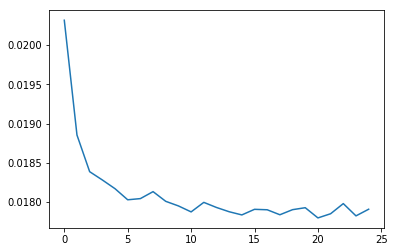

val_mean_absolute_error


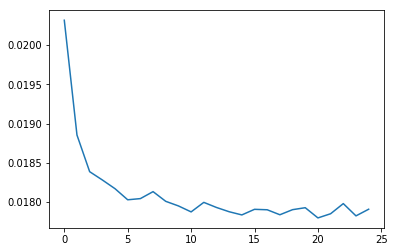

loss


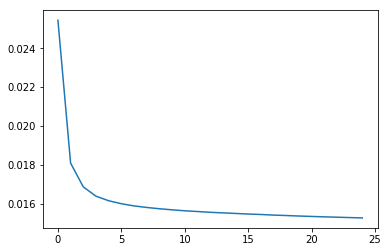

mean_absolute_error


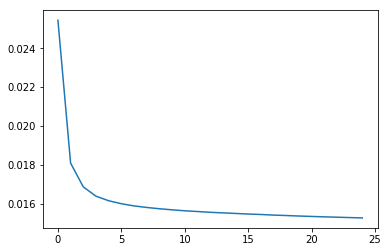

In [6]:
# Plot metrics
for k in history.history.keys():
    print(k)
    pyplot.plot(history.history[k])
    pyplot.savefig(k+'.png')
    pyplot.show()

## Error computation
* Root mean squared error and Mean absolute error
* Compute an histogram of errors

In [7]:
MAE = []
RMSE = []

for X_, Y_ in zip(X_test, Y_test): # Validation data
    # Predict and calculate mean absolute error
    mae = model.evaluate(np.array([X_]), np.array([Y_]), verbose=0)[0]
    
    Y_pred = model.predict(np.array([X_]))[0]
    rmse = sqrt(mean_squared_error(Y_pred, Y_))

    MAE.append(mae)
    RMSE.append(rmse)
    
print( "MAE error:", np.array(MAE).mean() )
print( "RMSE error:", np.array(RMSE).mean() )

MAE error: 0.017907181373561266
RMSE error: 0.03400246230053


### Mean absolute error

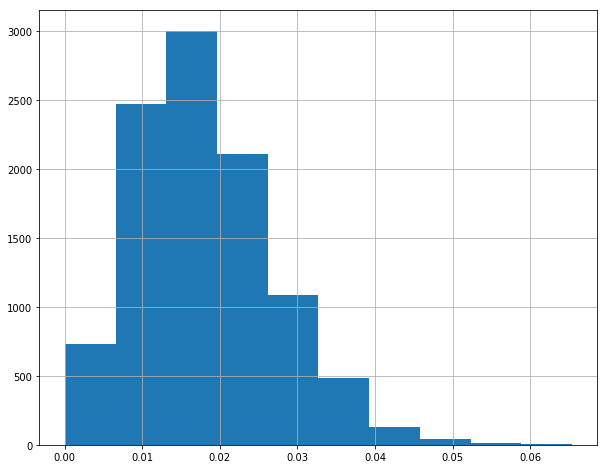

In [8]:
pd.Series(np.array(MAE)).hist(figsize=(10,8))

### Root mean squared error

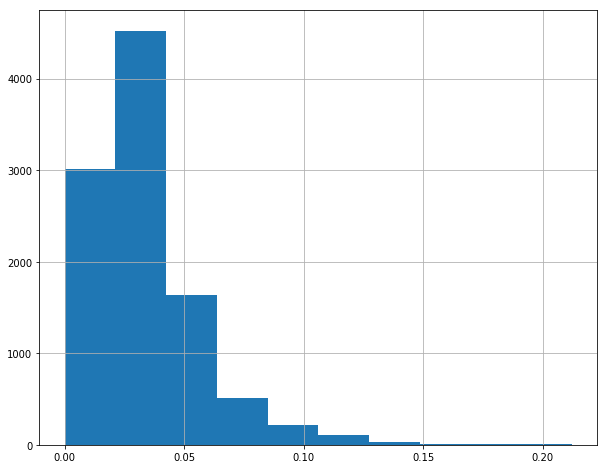

In [9]:
pd.Series(np.array(RMSE)).hist(figsize=(10,8))